In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import loguniform, randint, uniform
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import roc_curve, auc, log_loss
import altair as alt
from sklearn.impute import SimpleImputer
warnings.filterwarnings("ignore")
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [5]:
data = pd.read_csv('data/shots_2021.csv')

In [6]:
lst = ["shotType","shotAngle","arenaAdjustedShotDistance", "arenaAdjustedXCordABS", "arenaAdjustedYCordAbs",
       "awayEmptyNet", "awayPenalty1Length", "awayPenalty1TimeLeft", "awaySkatersOnIce", "awayTeamGoals",
       "defendingTeamDefencemenOnIce","defendingTeamForwardsOnIce", "distanceFromLastEvent", "event",
      "homeEmptyNet", "homePenalty1Length", "homePenalty1TimeLeft", "homeSkatersOnIce", "homeTeamGoals",
      "isHomeTeam", "isPlayoffGame", "lastEventCategory", "shooterLeftRight", 
      "shootingTeamDefencemenOnIce", "shootingTeamForwardsOnIce", "team","goal"]

In [7]:
lst_1 = ["shotType","shotAngle","arenaAdjustedShotDistance", "shooterLeftRight","xCordAdjusted",
         "yCordAdjusted","awayEmptyNet","awayTeamGoals",
       "defendingTeamDefencemenOnIce","defendingTeamForwardsOnIce", "distanceFromLastEvent", 
      "homeEmptyNet", "homeTeamGoals", "isPlayoffGame", "lastEventCategory",
      "shootingTeamDefencemenOnIce", "shootingTeamForwardsOnIce", "team","goal"]

In [8]:
data_1 = data[lst_1]

In [9]:
data_1['shootingTeamEmptyNet'] = np.where(data_1['team'] == 'HOME',data_1["homeEmptyNet"],data_1["awayEmptyNet"])
data_1['shootingTeamGoals'] = np.where(data_1['team'] == 'HOME',data_1["homeTeamGoals"],data_1["awayTeamGoals"])
data_1['defendingTeamEmptyNet'] = np.where(data_1['team'] == 'HOME',data_1["awayEmptyNet"],data_1["homeEmptyNet"])
data_1['defendingTeamGoals'] = np.where(data_1['team'] == 'HOME',data_1["awayTeamGoals"],data_1["homeTeamGoals"])

In [10]:
data_1 = data_1.drop(['homeEmptyNet','homeTeamGoals','awayEmptyNet','awayTeamGoals' ],axis = 1)

In [11]:
pd.DataFrame(data_1['goal'].value_counts()).T

,0,1
goal,112774,8697


In [12]:
X = data_1.drop('goal', axis = 1 )
y = data_1['goal']

In [13]:
X_train, X_test, y_train, y_test  = train_test_split(X,y,test_size = 0.5, random_state = 123)

In [14]:
train = pd.concat([X_train, y_train], axis = 1)

In [15]:
train.columns

Index(['shotType', 'shotAngle', 'arenaAdjustedShotDistance',
       'shooterLeftRight', 'xCordAdjusted', 'yCordAdjusted',
       'defendingTeamDefencemenOnIce', 'defendingTeamForwardsOnIce',
       'distanceFromLastEvent', 'isPlayoffGame', 'lastEventCategory',
       'shootingTeamDefencemenOnIce', 'shootingTeamForwardsOnIce', 'team',
       'shootingTeamEmptyNet', 'shootingTeamGoals', 'defendingTeamEmptyNet',
       'defendingTeamGoals', 'goal'],
      dtype='object')

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60735 entries, 69064 to 118270
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   shotType                      60733 non-null  object 
 1   shotAngle                     60735 non-null  float64
 2   arenaAdjustedShotDistance     60735 non-null  float64
 3   shooterLeftRight              60732 non-null  object 
 4   xCordAdjusted                 60735 non-null  int64  
 5   yCordAdjusted                 60735 non-null  int64  
 6   defendingTeamDefencemenOnIce  60735 non-null  int64  
 7   defendingTeamForwardsOnIce    60735 non-null  int64  
 8   distanceFromLastEvent         60735 non-null  float64
 9   isPlayoffGame                 60735 non-null  int64  
 10  lastEventCategory             60735 non-null  object 
 11  shootingTeamDefencemenOnIce   60735 non-null  int64  
 12  shootingTeamForwardsOnIce     60735 non-null  int64  
 

In [17]:
alt.Chart(train).mark_bar().encode(
    alt.X(alt.repeat(),type = 'quantitative', bin = alt.Bin(maxbins=40)),
    y = 'count()'
).facet('goal').repeat(['shotAngle'])

alt.RepeatChart(...)

In [35]:
alt.Chart(train).mark_point(opacity=0.5,size = 0.1).encode(
    x = 'xCordAdjusted',
    y = 'yCordAdjusted',
    #color = 'goal',
)

alt.Chart(...)

In [18]:
def display(i):
    graph = alt.Chart(train).transform_density(
    i,groupby=['goal'],
    as_=[ i, 'density']).mark_area(fill = None, strokeWidth=2).encode(
    x = (i),
    y='density:Q',stroke=alt.Stroke('goal:O', scale=alt.Scale(scheme='dark2'))).properties(width=200,height=200)
    return graph + graph.mark_area(opacity = 0.4).encode(color = alt.Color('goal',legend=None, scale=alt.Scale(scheme='dark2')))

In [19]:
display('shotAngle') | display('arenaAdjustedShotDistance') | display('distanceFromLastEvent')

alt.HConcatChart(...)

In [16]:
chart = alt.Chart(train).mark_line().encode(
    x = 'shotType',
    y = alt.Y('count()',stack=False),
    color = alt.Color('goal', legend=None, scale=alt.Scale(scheme='dark2'))
) 
chart + chart.mark_area(opacity=0.3).encode()

alt.LayerChart(...)

In [17]:
train.head()

,shotType,shotAngle,arenaAdjustedShotDistance,shooterLeftRight,xCordAdjusted,yCordAdjusted,defendingTeamDefencemenOnIce,defendingTeamForwardsOnIce,distanceFromLastEvent,isPlayoffGame,lastEventCategory,shootingTeamDefencemenOnIce,shootingTeamForwardsOnIce,team,shootingTeamEmptyNet,shootingTeamGoals,defendingTeamEmptyNet,defendingTeamGoals,goal
69064,WRIST,4.085617,15.0,R,75,1,2,3,145.825238,0,FAC,2,3,AWAY,0,1,0,0,0
32154,WRIST,31.504267,36.0,L,58,19,2,2,11.401754,0,MISS,2,2,AWAY,0,3,0,5,0
11793,WRIST,-29.981639,62.0,R,37,-30,2,3,44.384682,0,BLOCK,2,3,HOME,0,3,0,1,0
70132,BACK,-26.565051,22.0,R,73,-8,2,3,66.241981,0,HIT,2,3,AWAY,0,0,0,0,0
47718,WRIST,29.054604,10.0,R,80,5,2,3,32.249031,0,HIT,2,3,HOME,0,2,0,1,0


In [18]:
categorical_features  = ['shotType', 'lastEventCategory','team', 'shooterLeftRight' ]
binary_features = ['isPlayoffGame','shootingTeamEmptyNet', 'defendingTeamEmptyNet']

In [19]:
numeric_features = ['arenaAdjustedShotDistance',
 'distanceFromLastEvent',
 'shotAngle',
 'xCordAdjusted',
 'yCordAdjusted','defendingTeamDefencemenOnIce','defendingTeamForwardsOnIce',
 'defendingTeamGoals', 'shootingTeamDefencemenOnIce','shootingTeamForwardsOnIce','shootingTeamGoals']

In [20]:
preprocessor = make_column_transformer(
    (StandardScaler(),numeric_features),
    (OneHotEncoder(drop="if_binary", dtype=int), binary_features),
    (make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore")), categorical_features)
)

In [21]:
  param_dist = {
        "logisticregression__C": loguniform(1e-3, 1e3)
    }

In [22]:
pipe_lr_unopt = make_pipeline(
    preprocessor, LogisticRegression(penalty='l2', random_state=234, max_iter=10000, tol=.01)
)

In [23]:
pipe_lr = RandomizedSearchCV(pipe_lr_unopt, param_dist, n_iter = 10, n_jobs = -1, return_train_score = True)

In [24]:
pipe_lr.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['arenaAdjustedShotDistance',
                                                                                'distanceFromLastEvent',
                                                                                'shotAngle',
                                                                                'xCordAdjusted',
                                                                                'yCordAdjusted',
                                                                                'defendingTeamDefencemenOnIce',
                                                                                'defendingTeamForwardsOnIce',
                                                                                'defendingTeamGoals',
                                                                                'shootingTeamDefencemenOnIce',
                                                                                'shooting...
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['shotType',
                                                                                'lastEventCategory',
                                                                                'team',
                                                                                'shooterLeftRight'])])),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=10000,
                                                                 random_state=234,
                                                                 tol=0.01))]),
                   n_jobs=-1,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x144e43820>},
                   return_train_score=True)

In [25]:
pipe_lr.score(X_train,y_train)

0.9299744792952993

In [26]:
pipe_lr.score(X_test,y_test)

0.930222602739726

In [27]:
log_loss(y_test,pipe_lr.predict_proba(X_test)[:,1])

0.22888477956409334

In [28]:
roc_lr = roc_auc_score(y_test, pipe_lr.predict_proba(X_test)[:, 1])
roc_lr

0.7445332463330122

In [29]:
sum(pipe_lr.predict_proba(X_test)[:,1])/sum(y_test)

1.0062044532050156

In [30]:
pipe_lr_unopt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['arenaAdjustedShotDistance',
                                                   'distanceFromLastEvent',
                                                   'shotAngle', 'xCordAdjusted',
                                                   'yCordAdjusted',
                                                   'defendingTeamDefencemenOnIce',
                                                   'defendingTeamForwardsOnIce',
                                                   'defendingTeamGoals',
                                                   'shootingTeamDefencemenOnIce',
                                                   'shootingTeamForwardsOnIce',
                                                   'shootingT...
                                                  ['isPlayoffGame',
                                                   'shootingTeamEmptyNet',
                                                   'defendingTeamEmptyNet']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['shotType',
                                                   'lastEventCategory', 'team',
                                                   'shooterLeftRight'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, random_state=234,
                                    tol=0.01))])

In [31]:
ohe_features = pipe_lr_unopt.named_steps["columntransformer"].named_transformers_["pipeline"].get_feature_names_out(categorical_features).tolist()
feature_names = (numeric_features + binary_features + ohe_features)

In [32]:
data = {
    "coefficient": pipe_lr_unopt.named_steps["logisticregression"].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        pipe_lr_unopt.named_steps["logisticregression"].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "magnitude", ascending=False
)

In [33]:
coef_df.reset_index().head(10)

,index,coefficient,magnitude
0,defendingTeamEmptyNet,4.533791,4.533791
1,arenaAdjustedShotDistance,-1.713734,1.713734
2,shotType_WRAP,-1.257580,1.257580
3,lastEventCategory_STOP,1.003426,1.003426
4,xCordAdjusted,-0.830595,0.830595
5,shotType_SNAP,0.700144,0.700144
6,lastEventCategory_CHL,0.694106,0.694106
7,shotType_SLAP,0.648134,0.648134
8,lastEventCategory_HIT,-0.440702,0.440702
9,lastEventCategory_FAC,-0.418171,0.418171


In [34]:
alt.Chart(coef_df.reset_index().head(15), title = 'Feature Importance from Logistic Regression').mark_bar().encode(
    x = 'coefficient',
    y = alt.Y('index', sort = '-x'),
    color = alt.Color(scale = alt.Scale(scheme='dark2')))

alt.Chart(...)

In [35]:
roc_lr_unopt = roc_auc_score(y_test, pipe_lr_unopt.predict_proba(X_test)[:, 1])
roc_lr_unopt

0.7454252047371936

In [36]:
log_loss(y_test,pipe_lr_unopt.predict_proba(X_test)[:,1])

0.22869406791331887

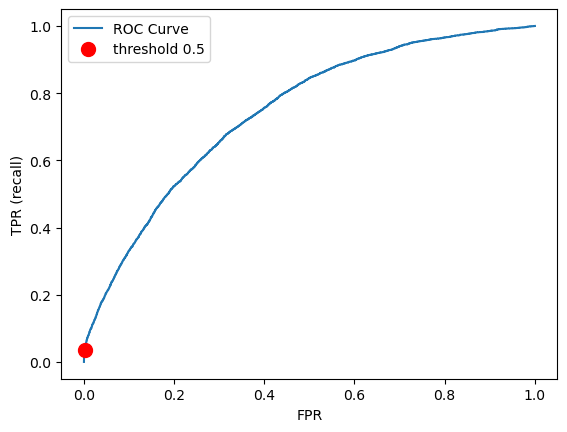

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [38]:
pipe_sgd = make_pipeline(preprocessor, SGDClassifier(loss = 'log_loss', class_weight = 'balanced'))

In [39]:
pipe_sgd.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['arenaAdjustedShotDistance',
                                                   'distanceFromLastEvent',
                                                   'shotAngle', 'xCordAdjusted',
                                                   'yCordAdjusted',
                                                   'defendingTeamDefencemenOnIce',
                                                   'defendingTeamForwardsOnIce',
                                                   'defendingTeamGoals',
                                                   'shootingTeamDefencemenOnIce',
                                                   'shootingTeamForwardsOnIce',
                                                   'shootingT...
                                                                dtype=<class 'int'>),
                                                  ['isPlayoffGame',
                                                   'shootingTeamEmptyNet',
                                                   'defendingTeamEmptyNet']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['shotType',
                                                   'lastEventCategory', 'team',
                                                   'shooterLeftRight'])])),
                ('sgdclassifier',
                 SGDClassifier(class_weight='balanced', loss='log_loss'))])

In [40]:
pipe_sgd.predict_proba(X_test)

array([[0.66168942, 0.33831058],
       [0.61739841, 0.38260159],
       [0.54271723, 0.45728277],
       ...,
       [0.40183124, 0.59816876],
       [0.7789513 , 0.2210487 ],
       [0.43265046, 0.56734954]])

In [41]:
param_grid = {
    'gradientboostingclassifier__min_samples_split': [100, 250, 500],
    'gradientboostingclassifier__max_depth': [3, 4, 5]
}

In [42]:
pip_gbc = make_pipeline(preprocessor, GradientBoostingClassifier(random_state=123))

In [43]:
gbc_opt = GridSearchCV(pip_gbc, param_grid=param_grid, cv=10)
gbc_opt

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['arenaAdjustedShotDistance',
                                                                          'distanceFromLastEvent',
                                                                          'shotAngle',
                                                                          'xCordAdjusted',
                                                                          'yCordAdjusted',
                                                                          'defendingTeamDefencemenOnIce',
                                                                          'defendingTeamForwardsOnIce',
                                                                          'defendingTeamGoals',
                                                                          'shootingTeamDefencemenOnIce',
                                                                          'shooting...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['shotType',
                                                                          'lastEventCategory',
                                                                          'team',
                                                                          'shooterLeftRight'])])),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=123))]),
             param_grid={'gradientboostingclassifier__max_depth': [3, 4, 5],
                         'gradientboostingclassifier__min_samples_split': [100,
                                                                           250,
                                                                           500]})

In [44]:
pip_gbc.fit(X_train, y_train) #

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['arenaAdjustedShotDistance',
                                                   'distanceFromLastEvent',
                                                   'shotAngle', 'xCordAdjusted',
                                                   'yCordAdjusted',
                                                   'defendingTeamDefencemenOnIce',
                                                   'defendingTeamForwardsOnIce',
                                                   'defendingTeamGoals',
                                                   'shootingTeamDefencemenOnIce',
                                                   'shootingTeamForwardsOnIce',
                                                   'shootingT...
                                                  ['isPlayoffGame',
                                                   'shootingTeamEmptyNet',
                                                   'defendingTeamEmptyNet']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['shotType',
                                                   'lastEventCategory', 'team',
                                                   'shooterLeftRight'])])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=123))])

In [45]:
roc_gbc = roc_auc_score(y_test, pip_gbc.predict_proba(X_test)[:, 1])
roc_gbc

0.7516624115149241

In [46]:
log_loss(y_test,pip_gbc.predict_proba(X_test)[:,1])

0.22678119070222139

In [47]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=100, random_state=123))

In [48]:
param_grid = {
    'randomforestclassifier__min_samples_leaf': [50, 100, 250, 500]
}

In [49]:
pipe_rf_opt = GridSearchCV(pipe_rf, param_grid=param_grid, cv=10)

In [50]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['arenaAdjustedShotDistance',
                                                   'distanceFromLastEvent',
                                                   'shotAngle', 'xCordAdjusted',
                                                   'yCordAdjusted',
                                                   'defendingTeamDefencemenOnIce',
                                                   'defendingTeamForwardsOnIce',
                                                   'defendingTeamGoals',
                                                   'shootingTeamDefencemenOnIce',
                                                   'shootingTeamForwardsOnIce',
                                                   'shootingT...
                                                                dtype=<class 'int'>),
                                                  ['isPlayoffGame',
                                                   'shootingTeamEmptyNet',
                                                   'defendingTeamEmptyNet']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['shotType',
                                                   'lastEventCategory', 'team',
                                                   'shooterLeftRight'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=123))])

In [51]:
log_loss(y_test,pipe_rf.predict_proba(X_test)[:,1])

0.3038023072008423

In [52]:
roc_gbc = roc_auc_score(y_test, pipe_rf.predict_proba(X_test)[:, 1])
roc_gbc

0.7183896744303828

In [53]:
def get_roc(actual, predictions):
    """
    Get the roc curve (and auc score) for the different models
    """
    fig = plt.figure()
    plt.title('ROC Curves')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    colors = ['b', 'g', 'p']

    for model, color in zip(predictions.keys(), colors):
        # Convert preds to just prob of goal
        preds = [pred[1] for pred in predictions[model]]

        false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, preds)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate, true_positive_rate, label=' '.join([model + ':', str(round(roc_auc, 3))]))

    # Add "Random" score
    plt.plot([0, 1], [0, 1], 'r--', label=' '.join(["Random:", str(.5)]))

    plt.legend(title='AUC Score', loc=4)
    fig.savefig("ROC_xG.png")


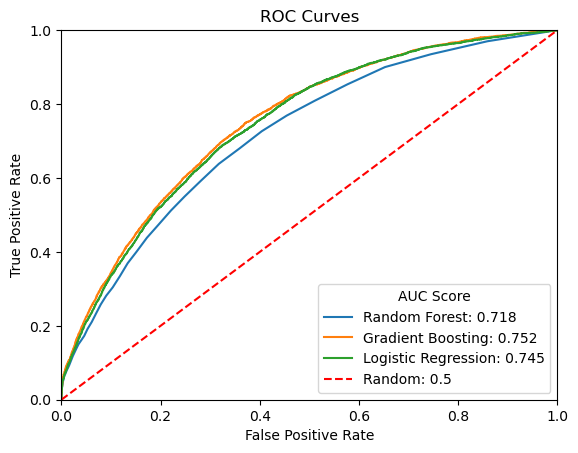

In [54]:
preds = {
    "Random Forest": pipe_rf.predict_proba(X_test),
    "Gradient Boosting": pip_gbc.predict_proba(X_test),
    "Logistic Regression": pipe_lr_unopt.predict_proba(X_test)
}
get_roc(y_test, preds)


In [55]:
log_loss(y_test,pip_gbc.predict_proba(X_test)[:,1])

0.22678119070222139

In [56]:
log_loss(y_test,pipe_rf.predict_proba(X_test)[:,1])

0.3038023072008423

In [57]:
log_loss(y_test,pipe_lr_unopt.predict_proba(X_test)[:,1])

0.22869406791331887